In [1]:

from IPython.display import display

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Specify the path to the test set folder
testset_path = '../storage/images/more_apples/original_test/'

# Specify the path to the saved trained model
model_path = "../hall_of_fame/100 accuracy on validation 91.7 on test/20230616-152021_resnet18_more_pinky_loss.pt"



# Define the transformation to be applied to the test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the trained model
model = torch.load(model_path)
model.to(device)
model.eval()

# Create the test set dataset
testset = ImageFolder(testset_path, transform=transform)

# Lists to store mislabeled images
mislabeled_fresh_apples = []
mislabeled_spoiled_apples = []

# Iterate over the images in the test set
for image_path, label in testset.imgs:
    # Load and preprocess the image
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        output = model(image)

    # Get the predicted label
    _, predicted_label = torch.max(output, 1)

    # Compare the predicted label with the ground truth label
    if predicted_label != label:
        if label == 0:  # Fresh Apples
            mislabeled_fresh_apples.append(image_path)
        elif label == 1:  # Spoiled Apples
            mislabeled_spoiled_apples.append(image_path)

# Print the list of mislabeled fresh apples
print("Mislabeled fresh apples:")
for image_path in mislabeled_fresh_apples:
    print(image_path)

# Print the list of mislabeled spoiled apples
print("Mislabeled spoiled apples:")
for image_path in mislabeled_spoiled_apples:
    print(image_path)


Mislabeled fresh apples:
../storage/images/more_apples/original_test/freshapples/45.jpg
../storage/images/more_apples/original_test/freshapples/46.jpg
../storage/images/more_apples/original_test/freshapples/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
../storage/images/more_apples/original_test/freshapples/81.jpg
../storage/images/more_apples/original_test/freshapples/images (3).jpg
Mislabeled spoiled apples:
../storage/images/more_apples/original_test/rottenapples/125.jpg
../storage/images/more_apples/original_test/rottenapples/127.jpg
../storage/images/more_apples/original_test/rottenapples/133.jpg
../storage/images/more_apples/original_test/rottenapples/AnyConv.com__images (90).jpg
../storage/images/more_apples/original_test/rottenapples/pg4fhm.jpg
../storage/images/more_apples/original_test/rottenapples/rp3fh8.jpg


In [4]:
image_url = '../storage/images/more_apples/original_test/freshapples/9.jpg'
img = cv2.imread(image_url)

In [5]:
print(image_url)

../storage/images/more_apples/original_test/freshapples/9.jpg


In [6]:
if img is None:
    print("Error: Failed to convert the image to RGB.")

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])


In [8]:
# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# # Ensure that the model's weight tensor is on the same device as the input tensor
# model.to(device)

In [9]:
# As usual for classication, the target is the logit output
# before softmax, for that category.

def myGradcam(model, input_tensor, label_to):
    target_layers = [model.layer4[-1]]  # Resnet18 and 50: model.layer4[-1], from GradCAM GitHub documentation
    targets = [ClassifierOutputTarget([label_to])]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255 * img), cam, cam_image))
    return [Image.fromarray(images)]  # Return a list with a single image



camImages=myGradcam(model, input_tensor,1)

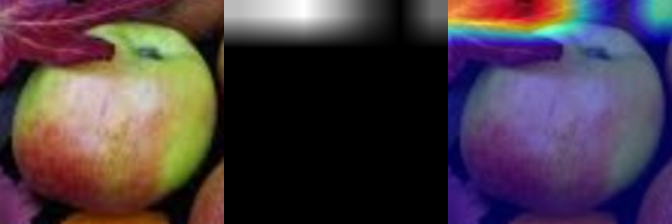

In [10]:

# Display the CAM image
for img in camImages:
    display(img)

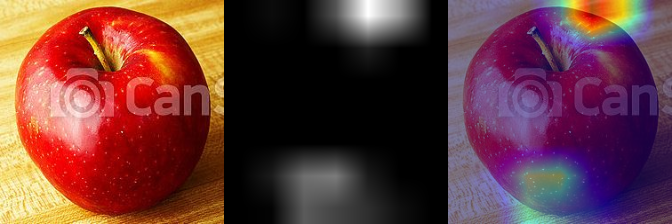

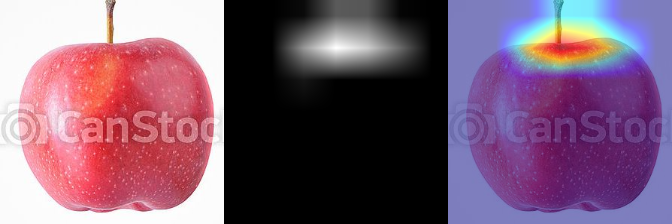

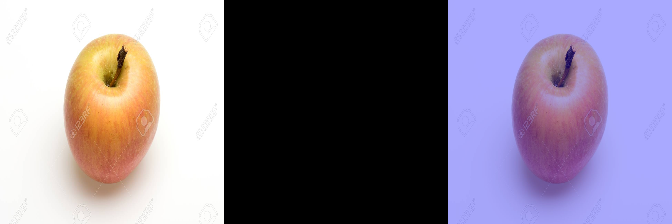

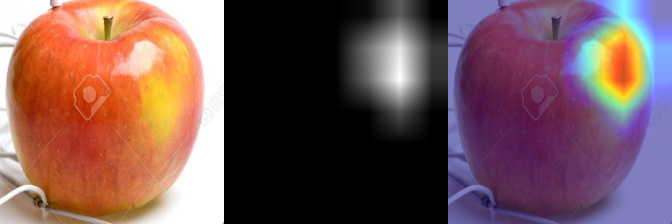

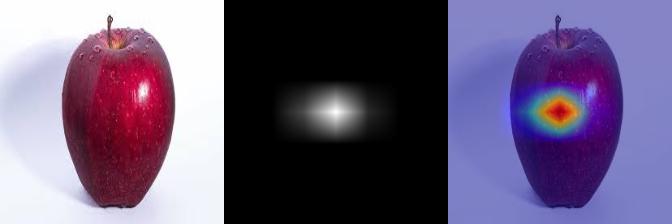

In [13]:
for img_path in mislabeled_fresh_apples:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        display(img)

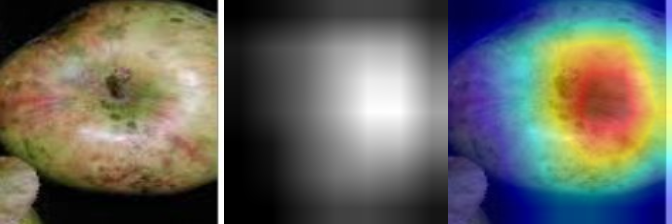

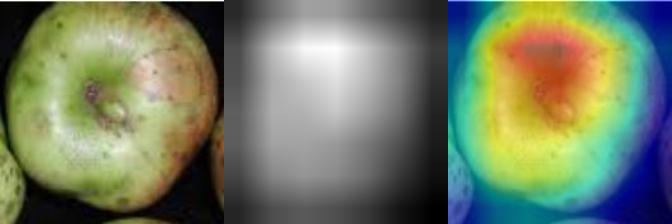

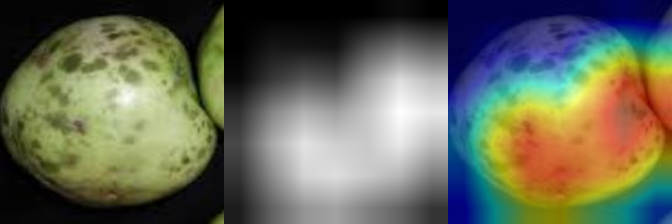

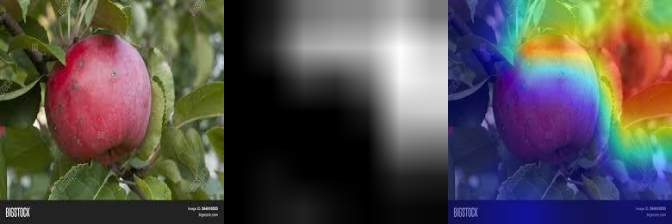

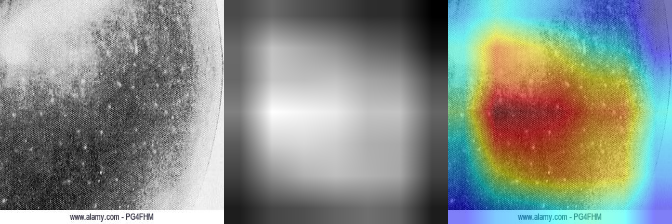

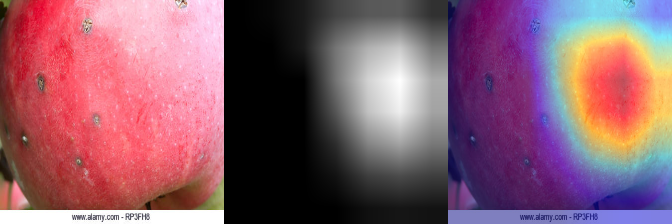

In [12]:
for img_path in mislabeled_spoiled_apples:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        display(img)

In [14]:
mislabeled_spoiled_apples

['../storage/images/more_apples/original_test/rottenapples/125.jpg',
 '../storage/images/more_apples/original_test/rottenapples/127.jpg',
 '../storage/images/more_apples/original_test/rottenapples/133.jpg',
 '../storage/images/more_apples/original_test/rottenapples/AnyConv.com__images (90).jpg',
 '../storage/images/more_apples/original_test/rottenapples/pg4fhm.jpg',
 '../storage/images/more_apples/original_test/rottenapples/rp3fh8.jpg']

In [15]:
correct_apples = [
    "../storage/images/more_apples/original_test/freshapples/images (6).jpg"
]

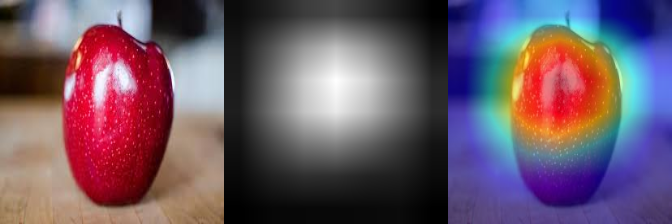

In [23]:
for img_path in correct_apples:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        display(img)

In [19]:
rotten_apples = ["../storage/images/more_apples/original_test/rottenapples/bwct8k.jpg"]

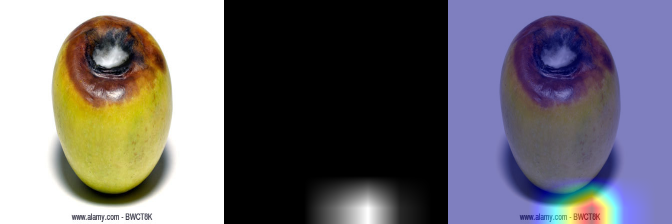

In [24]:
for img_path in rotten_apples:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    camImages=myGradcam(model, input_tensor,0)
    
    for img in camImages:
        display(img)